In [1]:
import scipy as sp
from matplotlib import pyplot as plt
%pylab inline
import yaml

Populating the interactive namespace from numpy and matplotlib


In [2]:
document='''
- crab_pulsar:
    spectrum : 
        powerlaw:
             K : 1
             gamma : 2
    spatial  : 
        point :
            ra : 83.63
            dec : 22.01
    polar :
        angle : 190
        degree : 17.8
- crab_nebula:
'''
print yaml.load(document)

[{'crab_pulsar': {'polar': {'angle': 190, 'degree': 17.8}, 'spectrum': {'powerlaw': {'K': 1, 'gamma': 2}}, 'spatial': {'point': {'dec': 22.01, 'ra': 83.63}}}}, {'crab_nebula': None}]


In [3]:
documet='''
- a
- b
'''
print yaml.load(documet)

['a', 'b']


In [78]:
from ximpol.srcmodel import xGenerator,xSpectralComponent,xSource

In [5]:
class xLightCurve(object):
    def __init__(self):
        self.f = None
        pass
    def Steady(self,rate):  
        self.f = rate
    def FunctionalLightCurve(self,function):
        self.f = function
        pass
    def TemplateLightCurve(self,times,rates):
        self.f = interpolate.UnivariateSpline(times,rates,k=1,s=0)
        pass
    def Phase(self,rate,period):
        pass
    def __call__(self,x):
        if isinstance(self.f,float): return sp.ones_like(x)*self.f
        return self.f(x)

Component (pl1+pl2)*(co1) added


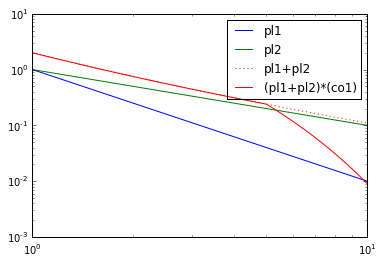

(184.55973191463613, -5.789183329711647)


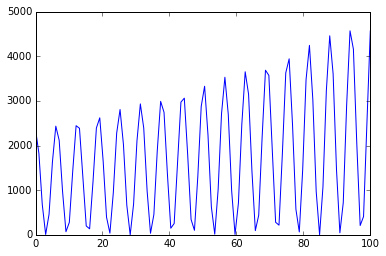

In [75]:
tmin=0
tmax=100
emin=1
emax=5

aeff=xAeff()
aeff.load_arf('../irf/fits/xipe_baseline.arf')


C=lambda t: 10.0*(1.0+sp.cos(t))
gamma=lambda t: -2+0.01*t

mySource=xSource('test',resolve_name=False)
mySource.setRADec(83.63,22.01)
print mySource.getLB()
spectrum=xSpectralComponent('spectrum')

times=sp.linspace(tmin,tmax,100)
flux=[]
events=[]
for t in times:
    spectrum.powerlaw(C(t),gamma(t))
    x,y = aeff.convolve(spectrum)
    f   = interpolate.UnivariateSpline(x,y,k=1,s=0)
    flux.append(f.integral(emin,emax))
    pass

lc   = interpolate.UnivariateSpline(times,flux,k=1,s=0)

S=xSimulator(lc,lc.integral)
S.setMinMax(tmin,tmax)
events_times=S.generate()
events_energies=[]
for evt in events_times:
    spectrum.powerlaw(C(evt),gamma(evt))
    x,y = aeff.convolve(spectrum)
    f   = interpolate.UnivariateSpline(x,y,k=1,s=0)
    S=xSimulator(f,f.integral)
    S.setMinMax(emin,emax)
    events_energies.append(S.generate(1)[0])
    pass



plt.plot(times,flux)


#spectrum.plot(sp.linspace(1,10,100))
#plt.xscale('log')
#plt.yscale('log')
#spectrum.polarization(0.1,89)
#mySource.addComponent(spectrum)


#temporalProfile=xLightCurve()
#temporalProfile.Steady(100.0)




#plt.plot(x,Crab.components[0](x))

#plt.plot(x,y)
#plt.plot(x,f(x))
#S=xSimulator(f,f.integral)
#S.setMinMax(1,10)

#S.generate()



171901


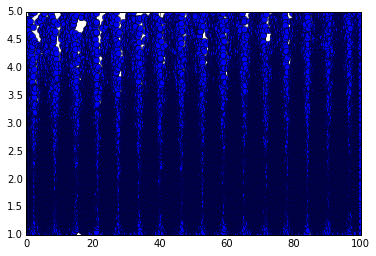

In [76]:
plt.plot(events_times,events_energies,'o')
print len(events_energies)

### 1 case of a simple constant function:
lc=xLightCurve()
lc.Steady(100.0)
S=xSimulator(lc)
S.setMinMax(0,100)
S.generate()
S.plot(100)

Done


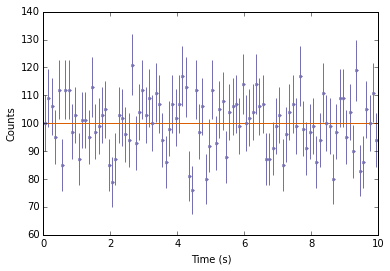

In [90]:
#1 case of a template (points in x and y):
tmin=0
tmax=10
x=sp.linspace(tmin,tmax,100)
y=1000.*sp.ones_like(x)
lc=xLightCurve()
lc.TemplateLightCurve(x,y)
S=xSimulator(lc)
S.SetMinMax(tmin,tmax)
S.generate()
S.plot(100)

Done


342

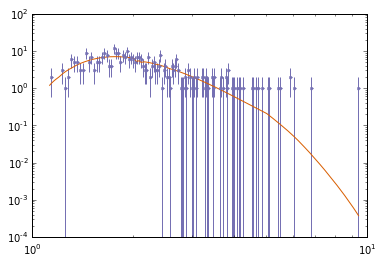

In [16]:
        

aeff=xAeff()
aeff.load_arf('../irf/fits/xipe_baseline.arf')


x,y=aeff.convolve(Crab.components[0])
f = interpolate.UnivariateSpline(x,y,k=1,s=0)
#plt.plot(x,Crab.components[0](x))

#plt.plot(x,y)
#plt.plot(x,f(x))
S=xSimulator(f,f.integral)
S.setMinMax(1,10)

S.generate()
S.plot()
plt.xscale('log')
plt.yscale('log')
S.nEvents

array([ 1.00548119,  1.00897353,  1.01402756, ...,  9.84914435,
        9.86744118,  9.88262894])

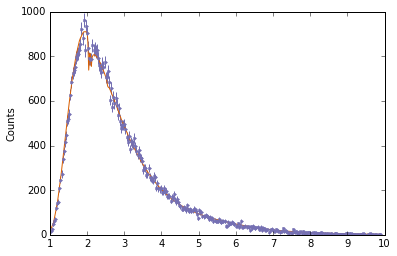

In [210]:
S.plot()
S.events

Done


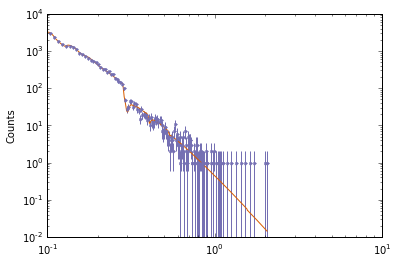

In [133]:
def dNdE(energy): 
    return 1.0*sp.power(energy,-4.8)

x,y=aeff.convolve(dNdE)
f = interpolate.UnivariateSpline(x,y,k=1,s=0)


#plt.plot(x,y)
#plt.plot(x,f(x))
S=xSimulator(f,f.integral)
S.SetMinMax(0.1,100)
S.generate()
S.plot()
plt.xscale('log')
plt.yscale('log')


In [20]:
import argparse
parser = argparse.ArgumentParser(description='ximpol simulator for X-ray polarimeter')
parser.add_argument('-c',, nargs='+', type=int, help='an integer to be summed')
    parser.add_argument(
        '--log', default=sys.stdout, type=argparse.FileType('w'),
        help='the file where the sum should be written')
    args = parser.parse_args()
    args.log.write('%s' % sum(args.integers))
    args.log.close()


In [83]:
sp.random.normal??

In [101]:
class xPsf():
    def __init__(self):
        self.psf=sp.random.normal
        pass
    def __call__(self,energy=0,theta=0):        
        return self.psf(0.0,15.0)

In [102]:
psf=xPsf()

In [105]:
psf()

-7.44764831069462

In [106]:
plt.hist2d??